## Obrada signala i određivanje frekvencije stimulusa

Snimljeni podaci se nalaze u folderu [data_collection\recorded_data](https://github.com/srete/ssvep-bci/tree/main/data_collection/recorded_data). Postupak obrade i određivanja frekvencije stimulusa je prikazan na primeru jednog ispitanika.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from signal_processing.preprocessing_functions import *
from signal_processing.cca import *

In [2]:
# Za plotovanje
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

#### I Ucitavanje podataka

In [3]:
fs = 200  # Hz
session_name = 'S03_b'
data_folder = r'data_collection\recorded_data\{}'.format(session_name)
data_path = data_folder + '\\data.csv'
rec_info_path = r'data_collection\recorded_data\{}\recording_info.txt'.format(session_name)
with open(rec_info_path, 'r') as f:
    rec_info = f.read()

df = pd.read_csv(data_path)  # Dataframe, samo zbog prikazA
freqs, data = format_data(data_folder)  # Formatirani podaci kao np.array
# Odbacujemo prvu sekundu snimanja
time = data[0, :, -1, 1*fs:]
t = np.arange(0, len(time[0])/fs, 1/fs)
data = data[:, :, :-1, 1*fs:]

# Informacije o poziciji elektroda iz txt fajla
EEG_CHN = {rec_info[rec_info.find(f'{i}:')+2 : rec_info.find(f'{i}:')+6].strip() : i for i in range(4)}
CHN_TO_POS = {v: k for k, v in EEG_CHN.items()}

# Prikaz podataka
print('\n********** RECORDING INFO **********')
print(rec_info)

print('\n\n********** NUMPY ARRAY **********')
n_blink_freqs, n_trial, n_chanels, n_samples = data.shape
print('Data shape = (n_blink_freqs, n_trial, n_chanels, n_samples) = ', data.shape)

print('\n********** DATAFRAME **********')
df.head()




********** RECORDING INFO **********
Session name: S03
Date: 2023-05-24
Positions of EEG electrodes: 
	0: Oz
	1: O1
	2: O2
	3: POz
Frequencies shown on screen:  [7.5, 8.57, 10, 12]
Recording time: 21
	Recording started at: /
	Recording ended at: /

Additional information:
All at once


********** NUMPY ARRAY **********
Data shape = (n_blink_freqs, n_trial, n_chanels, n_samples) =  (4, 1, 4, 3998)

********** DATAFRAME **********


,blink_freq,ch1,ch2,ch3,ch4,timestamp
0,10.0,13.583317,19.716753,20.229119,10.681154,1.684949e+09
1,10.0,25.678153,55.586133,43.756829,35.012943,1.684949e+09
2,10.0,2.505733,-1.398723,4.469180,3.182655,1.684949e+09
3,10.0,22.622655,20.894821,19.855129,13.534698,1.684949e+09
4,10.0,28.572836,59.733682,43.192105,31.650773,1.684949e+09


### II Filtriranje EEG signala

Filtriranje EEG signala sastoji se iz sledećih koraka:
1. Uklanjanje DC komponente jer u row podacima svaki EEG kanal ima različit DC ofset 
2. Notch filtar na 50Hz za otklanjanje šuma mreže
3. Čebiševljev filtar - propusnik opsega sa parametrima
    - propusni opseg od 6-32Hz kako bi se zadržale samo frekvencije koje su korišćene kao stimulus (7.5-30Hz)
    - red filtra 4

Primer filtriranja signala urađen je na prvih 5s snimanja.

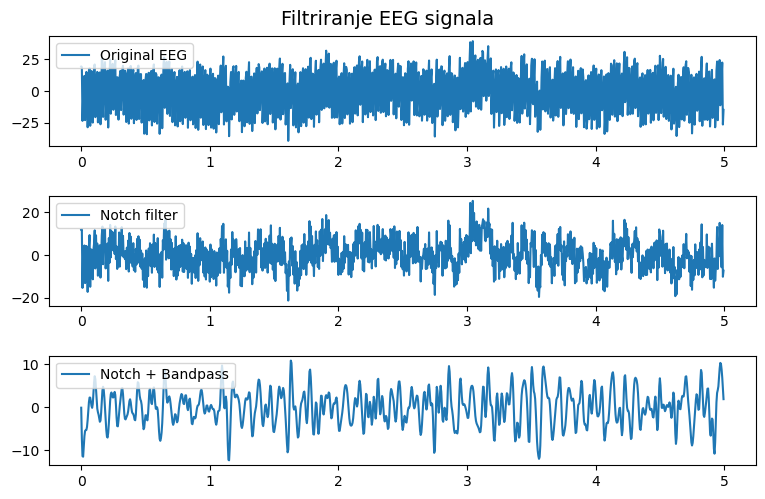

<Figure size 640x480 with 0 Axes>

In [4]:
# Uklanjanje DC komponente
noisy_data = data[:, :, :, :5*fs]
ch_i = 0
trial_i = 0
freq_i = 0

t5 = t[:5*fs]
noisy_data = np.apply_along_axis(remove_dc_offset, -1, noisy_data)
# Notch filter
quality_factor = 20
notch_freq = 50.0  # Hz
data_notch = np.apply_along_axis(notch_filter, -1, noisy_data, fs, notch_freq, quality_factor)
# Chebyshev bandpass filter
low = 6  # Hz
high = 32  # Hz
order = 4
rp = 0.1
data_filtered = np.apply_along_axis(cheby_filter, -1, data_notch, fs, low, high, order, rp)

fig, axs = plt.subplots(3, 1, figsize=(8, 5))
plt.figure()
fig.tight_layout(pad=1.5)
axs[0].plot(t5, noisy_data[freq_i, trial_i, ch_i, :], label='Original EEG')
axs[0].legend(loc='upper left')
axs[1].plot(t5, data_notch[freq_i, trial_i, ch_i, :], label='Notch filter')
axs[1].legend(loc='upper left')
axs[2].plot(t5, data_filtered[freq_i, trial_i, ch_i, :], label='Notch + Bandpass')
axs[2].legend(loc='upper left')
# add title to figure
fig.suptitle(f'Filtriranje EEG signala', y=1)
plt.show()

### III Spektar filtriranog signala

Kod SSVEP stimulacije očekujemo da u spektru snimljenog signala postoji pik na frekvenciji koja odgovara frekvenciji stimulusa. Zbog toga je urađena Furijeova transformacija isfiltriranog signla (primer za prvih 5s snimanja) i prikazani su grafici za sve frekvencije stimulusa. 

Ne očekujemo da sa svakim kanalom uočimo pik za svaku frekvenciju, pa su na posebnog grafiku izdvojeni kanali gde se pik jasno uočava. 

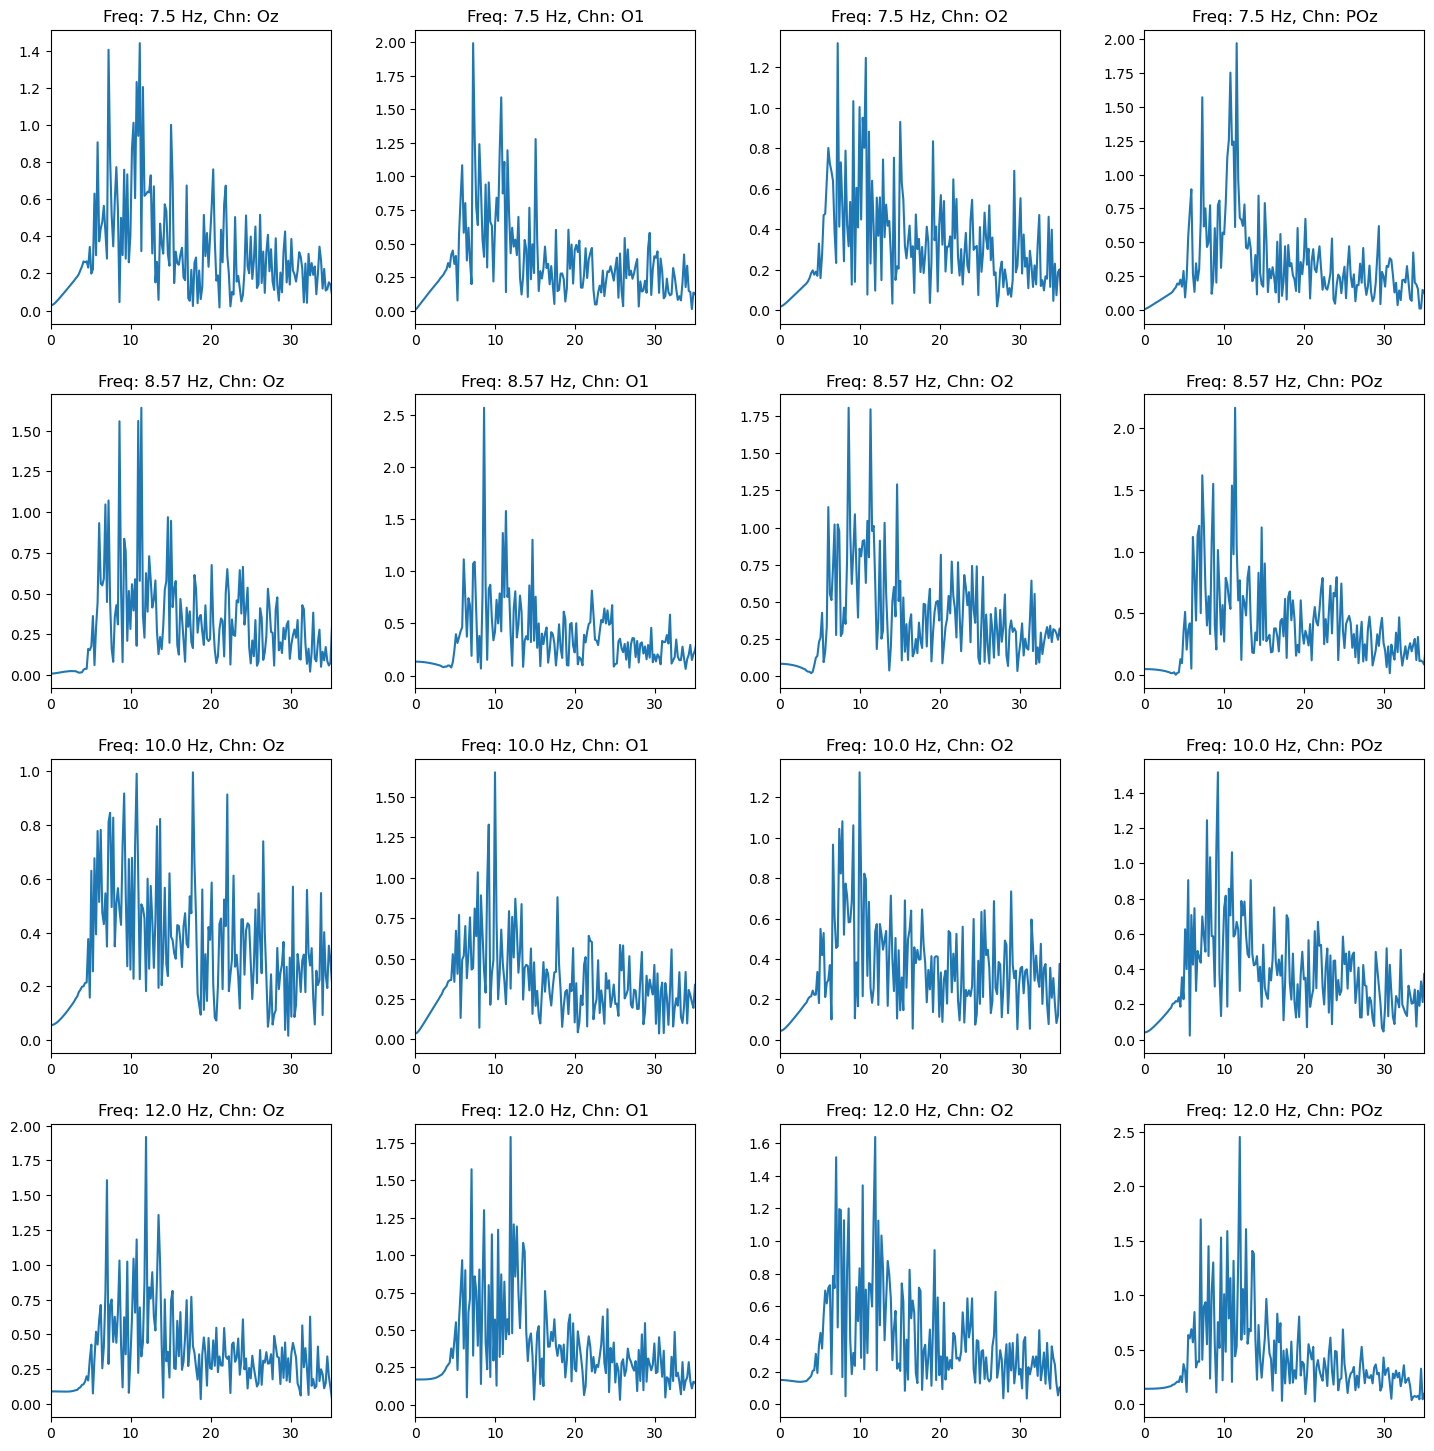

U ovom primeru O1 elektroda pokazuje najbolje rezultate za sve frekvencije.


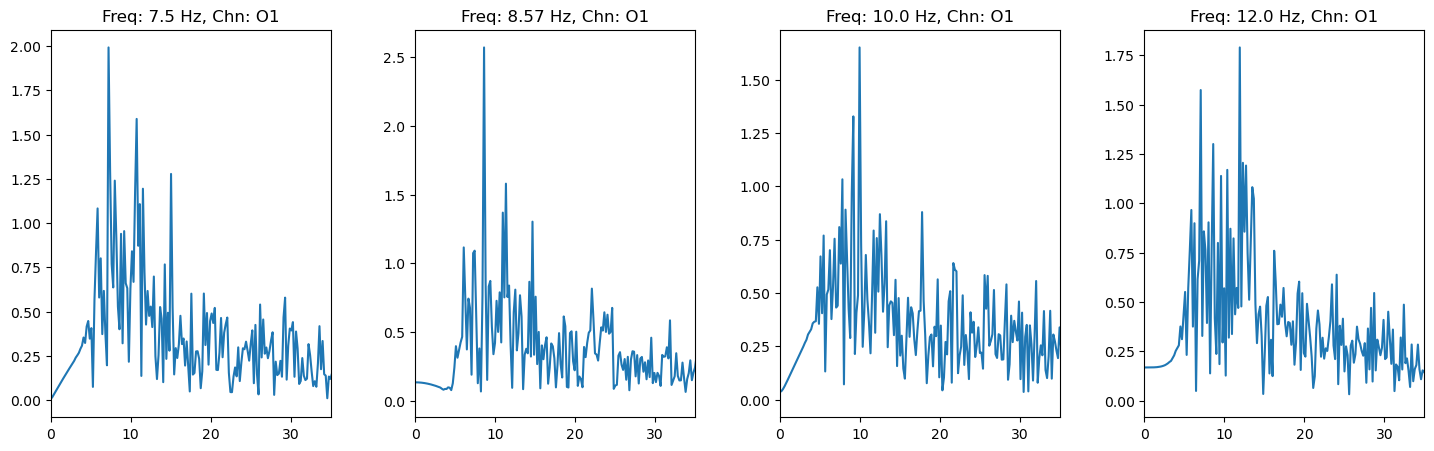

In [5]:
data_fft = np.apply_along_axis(signal_fft, -1, data_filtered, fs)
fft_fs = data_fft[0, 0, 0, 1, :]
data_fft = data_fft[:, :, :, 0, :]
plot_trial(0, data_fft, fft_fs, freqs, CHN_TO_POS)
print('U ovom primeru O1 elektroda pokazuje najbolje rezultate za sve frekvencije.')

chn_to_plot = ['O1', 'O1', 'O1', 'O1']
fig, axs = plt.subplots(1, n_blink_freqs, figsize=(15, 5))
fig.tight_layout(pad=3.0)
for i in range(n_blink_freqs):
    axs[i].plot(fft_fs, data_fft[i, 0, EEG_CHN[chn_to_plot[i]], :])
    axs[i].set_title('Freq: ' + str(round(freqs[i], 2)) + ' Hz, Chn: ' + chn_to_plot[i])
    axs[i].set_xlim([0, 35])
plt.show()

Na spektrogram za sve frekvencije za kanal O1 mogu se uočiti vremenski trenuci u kojima se javlja reakcija na stimulus.

<Figure size 640x480 with 0 Axes>

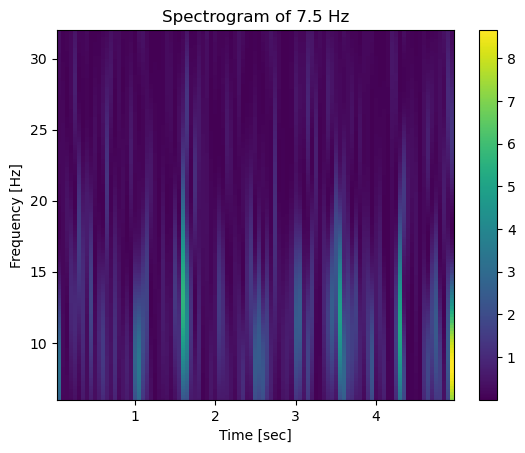

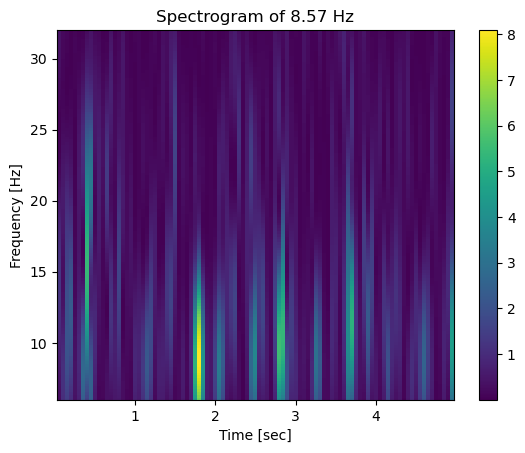

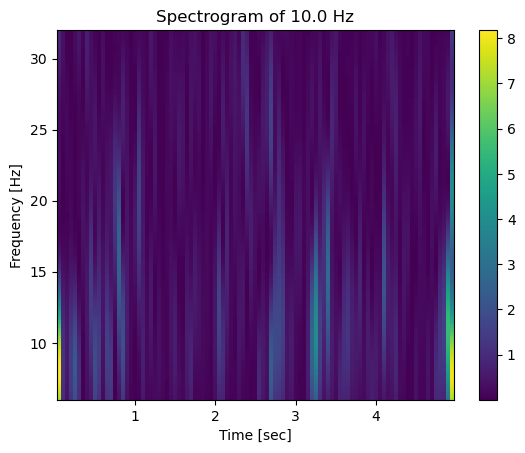

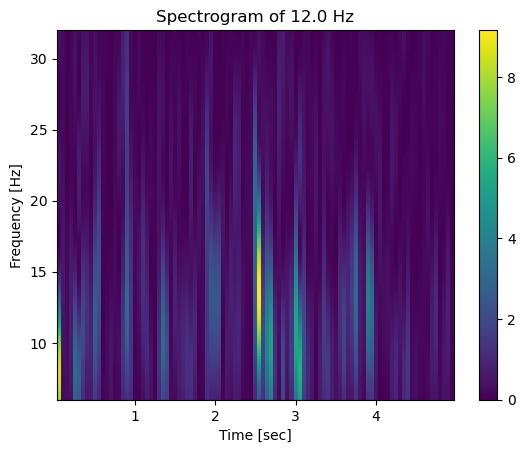

In [8]:
plt.figure()
for freq_idx in range(n_blink_freqs):
    #plt.subplot(2, 2, freq_idx+1)
    plot_spectrogram(data_filtered[freq_idx, 0, EEG_CHN['O1'], :], fs, freq_idx, freqs)

### IV Canonical Correlation Analysis (CCA)

Consider two multidimensional variables $X$, $Y$ where $X$ refers to the set of multi-channel EEG data and $Y$ refers to the set of reference signals of the same length as $X$. The linear combinations of $X$ and $Y$ are given as $x = X'W_{x}$ and $y = Y'W_{y}$. CCA finds the weights, $W_{x}$ and $W_{y}$ that maximize the correlation between $x$ and $y$ by solving (1). The maximum of $\rho$ with respect to $W_{x}$ and $W_{y}$ is the maximum correlation.

$$\max_{W_{x},W_{y}} \rho(x,y) = \frac{\mathbb{E}{[W_{x}'XY'W_{y}]}}{\sqrt{\mathbb{E}{[W_{x}'XX'W_{x}]}\mathbb{E}{[W_{y}'YY'W_{y}]}}}$$

The reference signals $Y_{n}$  are defined as:

$$Y_{n} = \begin{bmatrix} \sin({2 \pi f_{n}t}) \\ \cos({2 \pi f_{n}t}) \\ \vdots \\ \sin({4 \pi  f_{n}t}) \\ \cos({4 \pi  f_{n}t}) \end{bmatrix},t = \begin{bmatrix} 
    \frac{1}{f_{s}}
    \frac{2}{f_{s}}
    \dots
    \frac{N_{s}}{f_{s}}
    \end{bmatrix}$$
    
where $Y_{n} \in \mathbb{R}^{2 N_{h} \times N_{s}} $, $f_{n}$ is the stimulation frequency, $f_{s}$ is the sampling frequency, $N_{s}$ is number of samples, and $N_{h}$ is the number of harmonics. Here, $N_{h}=2$. The canonical correlation features $\rho_{f_{i}}$, where $i = 1,2,...,7$ are extracted for each segment of the EEG data, and the output class $C$ for a given sample can be determined as: $C = \argmax (\rho_{f_{i}})$



In [11]:
refresh_rate = 60 # Hz
target_freqs = np.array([refresh_rate/i for i in range(3, 11)])  # 6-20 Hz
target_freqs = freqs
ref = np.array([get_cca_reference_signals(data_filtered.shape[-1], f, fs) for f in target_freqs])

predictions, labels = cca_classify(data_filtered, ref)

print('\n'+'-'*20)
print('Labels\t\tPredictions')
print('-'*20)
for i in range(len(predictions)):
    print(f'{freqs[labels[i]] : .2f}\t\t{target_freqs[predictions[i]] : .2f}')
print('-'*20+'\n')


Max correlation: 0.350794492859589, Min correlation: 0.16675805358715293
Max correlation: 0.490692696106559, Min correlation: 0.11011687924894285
Max correlation: 0.6244192916348665, Min correlation: 0.1183946080201587
Max correlation: 0.2755922769601211, Min correlation: 0.15773008314020978

--------------------
Labels		Predictions
--------------------
 7.50		 7.50
 8.57		 8.57
 10.00		 10.00
 12.00		 7.50
--------------------

